In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# source files
import sys
sys.path.append('scripts/')
from scripts.calibrated_regression import CalibratedRegression
from scripts.data_loader import load_quadratic_data

import pymc3 as pm

# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline

---

# Experiments

## Experiment 1: Polynomial Regression Model
### Misspecified Noise in the Model

Priors:

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=1
$$

Note that $\sigma=1$ but the true $\sigma$ of the data is 2. This is an example of model misspecification and cannot be avoided as we don't know what the true $\sigma$ of the data is.

### Creating Data For Experiments 1 and 2

(1250,) (250,) (1250,) (250,)


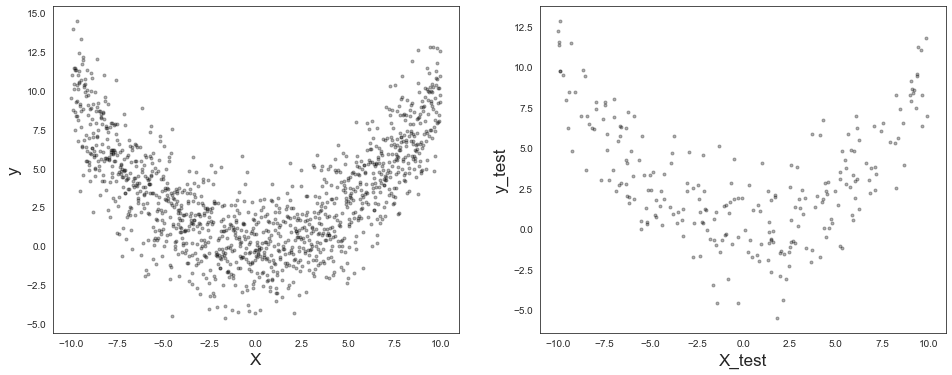

In [2]:
X, X_test, y, y_test = load_quadratic_data()
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

### Modeling

In [3]:
with pm.Model() as model_misspecified:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1158.67draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.098877,0.000930,0.000026,0.097066,0.100651,1029.308765,0.999556
b,0.007164,0.004877,0.000123,-0.002394,0.016499,1359.368575,0.999774
c,-0.017958,0.041322,0.001304,-0.099184,0.062104,1023.345419,0.999545


In [4]:
def posterior_predictive(x, a, b, c, sigma=1):
    '''Returns samples from posterior predictive.
    
    Parameters
    ----------
    x : array-like
        Data
    a : np.array
        Posterior samples of a
    b : np.array
        Posterior samples of b
    c : np.array
        Posterior samples of c
    sigma : float
        Standard deviation of observation noise
            
    Returns
    -------
    samples : np.array
    '''
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    samples = (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
    return samples

In [5]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model_misspecified, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,5.370247,0.238075,0.002,0.100
1,8.345564,8.731677,0.966,0.804
2,-2.488326,-3.205667,0.000,0.044
3,-1.901268,1.586870,0.909,0.732
4,4.903269,2.692670,0.633,0.532


[0.         0.563      0.99940476]


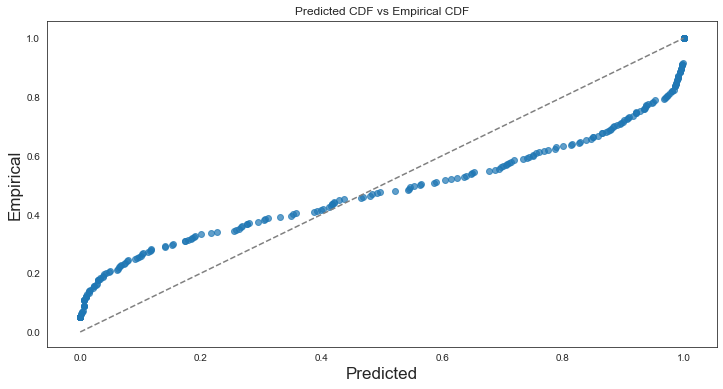

In [6]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

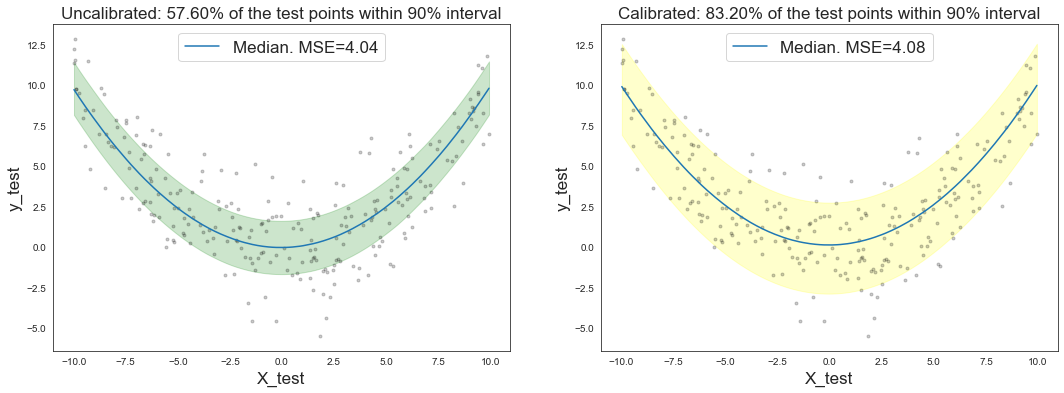

In [7]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

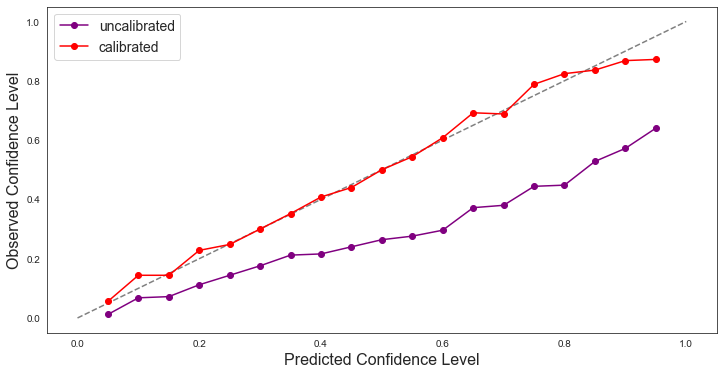

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

## Experiment 2: Polynomial Regression Model
### Misspecified Noise in the Model

Priors:

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=2
$$

Note that $\sigma=2$ here, which is how the data was generated

In [9]:
with pm.Model() as model_correct:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=2, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1366.92draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.098938,0.001849,0.000054,0.094998,0.102264,1088.255943,0.999500
b,0.006970,0.009673,0.000251,-0.011483,0.025662,1465.875431,1.000864
c,-0.020705,0.084485,0.002524,-0.199489,0.137929,1061.576896,1.000010


In [10]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c, 'sigma':2}
calib = CalibratedRegression(X, y, model_misspecified, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,-2.968646,3.175946,0.881,0.868
1,-1.687792,-4.628698,0.006,0.012
2,-6.557705,4.377472,0.518,0.552
3,-3.408939,5.740281,0.990,0.980
4,7.398266,8.761415,0.946,0.932


[0.0365 0.5    0.972 ]


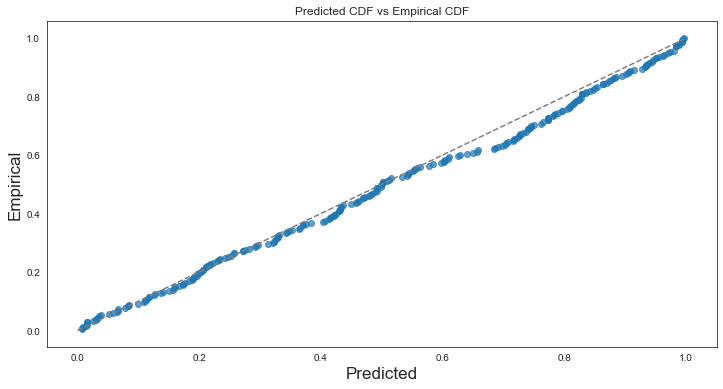

In [11]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

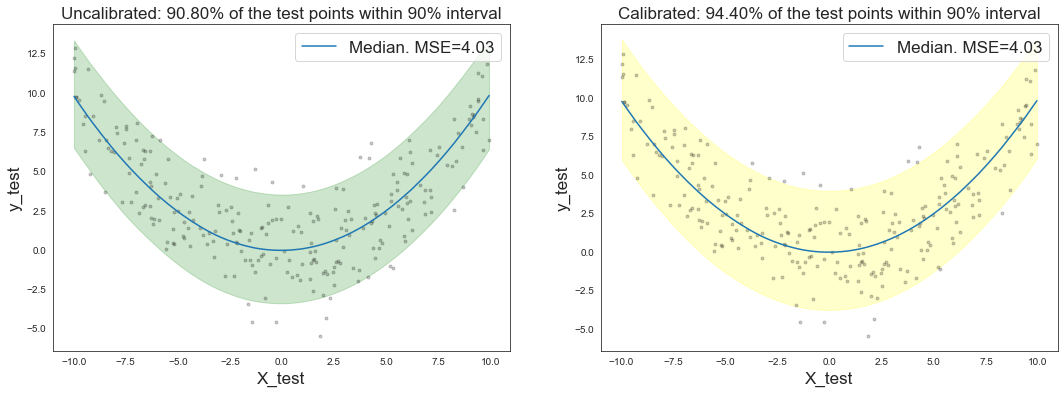

In [12]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

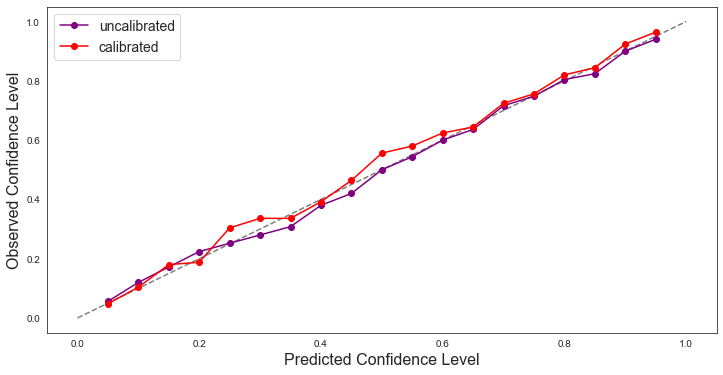

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

## Experiment 3: Polynomial Regression Model
### Dataset Shift: training data and test data are different

Priors:

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=1
$$

Note that $\sigma=1$ here, which is how the data was generated

### Creating Data For Experiment 3

(1250,) (250,) (1250,) (250,)


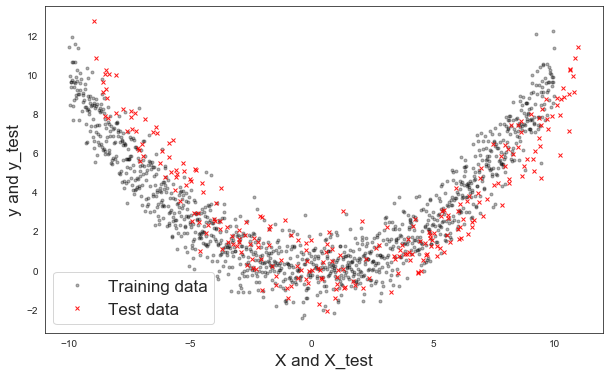

In [14]:
X, X_test, y, y_test = load_quadratic_data(scale=1)
dif = 1
X_test += dif
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.set_xlabel('X and X_test', fontsize=17)
ax.set_ylabel('y and y_test', fontsize=17)

ax.plot(X, y, 'o', markersize=3, color='black', alpha=0.3, label='Training data')
ax.plot(X_test, y_test, 'x', markersize=4, color='red', alpha=0.9, label='Test data')
ax.legend(fontsize=17)
ax.set_xlim(-11, 11+dif);

### Modeling

In [15]:
with pm.Model() as model_correct:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 762.76draws/s] 


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.099020,0.000923,0.000026,0.097304,0.100894,1184.336543,1.003461
b,-0.000695,0.004868,0.000152,-0.010183,0.009125,1233.736544,0.999685
c,0.041030,0.041548,0.001192,-0.040764,0.120233,1258.781020,0.999941


In [16]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c, 'sigma':1}
calib = CalibratedRegression(X, y, model_misspecified, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,-8.732488,8.101623,0.684,0.684
1,-3.168779,0.967283,0.469,0.508
2,3.355570,2.114100,0.810,0.812
3,-2.595063,0.268422,0.332,0.312
4,-4.142762,1.820447,0.519,0.560


[0.0645     0.471      0.96383333]


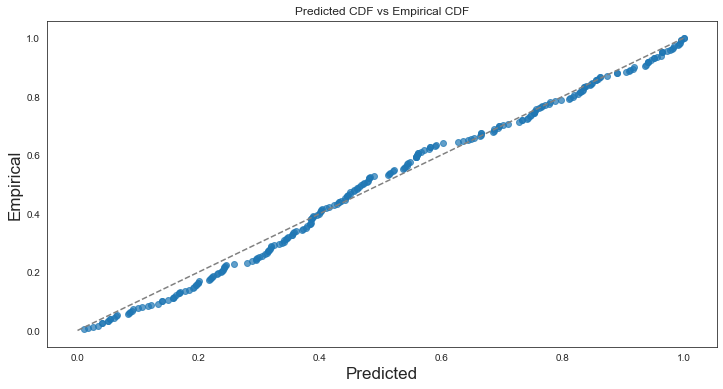

In [17]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

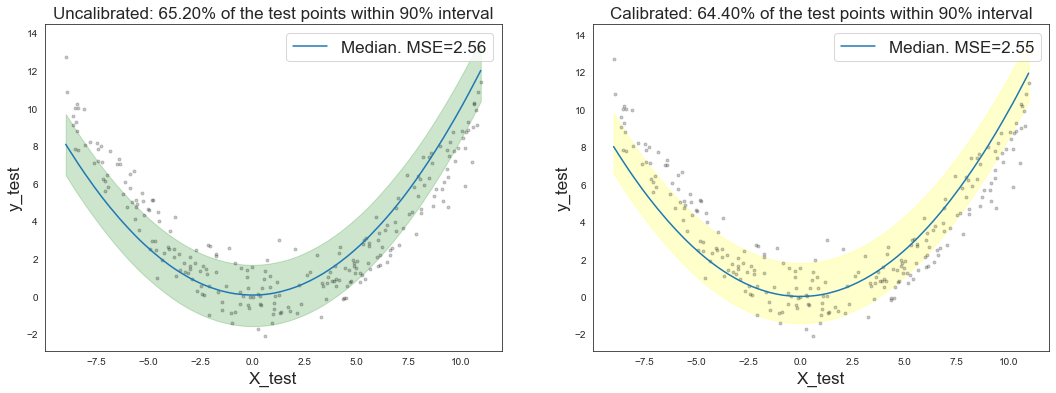

In [18]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

---